<a href="https://colab.research.google.com/github/cuongme-ja/darth-day-ja-2024/blob/main/FunctionApproximation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Networks as Function Approximators

# Agenda
- Jupyter notebook intro
- What is a function
- Start from basic scenario and then progress into slightly more complicated scenarios
  - Handcraft Simple Linear Function Approximator
  - Simple Linear Function in Tensorflow
  - Linear function with 2 inputs
  - Simple Quadratic function $ y = x^2 $
  - A math & english score pass/fail function

In [ ]:
import numpy as np
# from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.animation
from matplotlib import cm
from IPython import display
import time
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

# plt.ioff()
# plt.ion()
%matplotlib inline
plt.rcParams["animation.html"] = "jshtml"

# Quick jupyter notebook intro

In [ ]:
a = 6
print(a)

In [ ]:
a = 7

In [ ]:
a = np.array([3, 4, 5, 6, 7, 8])
a = a.reshape((2,3))
print("  ")
print(a)
print(a.shape)
print("  ")
a = np.expand_dims(a, 1)
print(a)
print(a.shape)

print(" ")
print(a[0][0][1])

# What is function approximation?

# What is a Function
## Linear
 ```python
 def linear(x):
  a = 1
  b = 2
  return ax + b
 ```
 $ y = ax + b$

 ## Linear 2
 ```python
 # x is an array of size 2.
 def linear2(x):
   a = [1, 3]
   b = [2]
   return a[0]*x[0] + a[1]*x[1] + b
 ```
 $ y = a_1*x_1 + a_2*x_2 + b $
 or
 $ y = AX + b $ where A & X are arrays of size 2

# An linear function
## $ f(x) = ax + b $
## $y=ax+b$

In [ ]:
x = np.arange(-10, 11).astype("float32")
print("x:", x)
y_actual = 0.5 * x + 2     # a*x+b
print("y_actual:", y_actual)

y = y_actual + np.random.randn(21) * 2 # Generate some data and add noise
y = y.astype("float32")
print("y (sample data):", y)

plt.plot(x, y_actual)
plt.scatter(x, y)
plt.show()

 # A random guess
 Let's take a random guess on `a` and `b` values

In [ ]:

#randomly initialize weights
w_a = 0
w_b = 0

y_estimate = w_a * x + w_b
print("y_actual", y_actual)
print("y_estimate:", y_estimate)

plt.scatter(x, y)
plt.plot(x, y_actual)
plt.plot(x, y_estimate)
plt.axis([-11., 11., -10., 10.])
plt.show()

### Discussion Point
 - What's the best way to measure how wrong we are?

 # Loss Function (or error calculation)
 $ l1 error = guess - actual $

 $ l2 = l1 ^ 2 $

 (mean square error) $ mse  = mean(l2) $

In [ ]:
# error calculation
l1_error = abs(y - y_estimate)
print("L1 error:")
print(l1_error)
print("L1 sum:", l1_error.sum(), "\n")

# error squared
print("L2 error:")
l2_error = l1_error ** 2
print(l2_error)
print("L2 sum:", l2_error.sum())

 ### Discussion point:
 - Difference between L1 and L2 error
 - How does L1 and L2 change as your change your guess of w_a
 - How does L1 and L2 change as your change your guess of w_b
 - If you didn't know the exact answer to a and b, could you have arrived at a fairly good guess after x number of tries? How would you go about it?

 # Why L2 error

In [ ]:
l2_x = np.arange(-10, 11)
l2_y = l2_x ** 2
plt.plot(l2_x, l2_y)
plt.scatter(l2_x, l2_y)
plt.show()

 # Gradient

 ![title](https://github.com/whathelll/Reinforcement-Learning/raw/master/FunctionApproximation/images/gradient.png)

 # Gradient decent
 https://en.wikipedia.org/wiki/Gradient_descent
 ## Find: $$gradient = \frac{\text{change in loss}}{\text{change in } w_a}$$
 ## Then: $$w_a = w_a - 0.01 * gradient$$
 #### where 0.01 is referred to as the learning rate which you can adjust

 # Learning Process
 - run the model with sample data
 - $ y = ax + b$
 - $ l2 = (y - y_actual)^2 $
 - $ loss = mean (l2) $  <- divide the sum of all l2 errors by total number of samples we ran
 - Find the gradient of loss with respect to a and b, using partial derivatives calculation
 - Adjust a: $ a = a - learning rate * gradient_a $
 - Adjust b: $ b = b - learning rate * gradient_b $
 - run the model again with the new a & b

### Define a chart class to help with drawing

In [ ]:
# Define a class to help with drawing chart animations
class Chart:
  def __init__(self, frames=50):
    self.frames=max(1, frames)
    self.x = []
    self.y = []
    self.y_actual = []
    self.y_estimate = []
    self.error_history = []
    self.w_a = []
    self.w_b = []

    self.figure = plt.figure(figsize=(15,10))
    self.ax1_1 = self.figure.add_subplot(2, 2, 1)
    self.ax1_1.set_title("Data and sample")
    self.scatter = self.ax1_1.scatter([],[])
    self.line_actual, = self.ax1_1.plot([], [])
    self.line_estimate, = self.ax1_1.plot([], [])

    self.ax1_2 = self.figure.add_subplot(2, 2, 2)
    self.line_error, = self.ax1_2.plot([])
    self.ax1_2.set_title("Error history")

    self.ax2_1 = self.figure.add_subplot(2, 2, 3)
    self.line_w_a, = self.ax2_1.plot([])
    self.ax2_1.set_title("w_a")

    self.ax2_2 = self.figure.add_subplot(2, 2, 4)
    self.line_w_b, = self.ax2_2.plot([])
    self.ax2_2.set_title("w_b")

  def append(self, x, y, y_actual, y_estimate, error_history, w_a, w_b):
    self.x.append(x)
    self.y.append(y)
    self.y_actual.append(y_actual)
    self.y_estimate.append(y_estimate)
    self.error_history.append(error_history)
    self.w_a.append(w_a)
    self.w_b.append(w_b)

  def update_axis(self):
    maxy = max(np.max(self.y), np.max(self.y_actual), np.max(self.y_estimate)) + 1
    miny = min(np.min(self.y), np.min(self.y_actual), np.min(self.y_estimate)) - 1
    self.ax1_1.axis([np.min(self.x)-1, np.max(self.x)+1, miny, maxy])
    self.ax1_2.axis([-0.5, len(self.error_history), -1, max(self.error_history[len(self.error_history)-1])])
    self.ax2_1.axis([-0.5, len(self.w_a), np.min(self.w_a[len(self.w_a)-1])-1, np.max(self.w_a[len(self.w_a)-1])+1])
    self.ax2_2.axis([-0.5, len(self.w_b), np.min(self.w_b[len(self.w_b)-1])-1, np.max(self.w_b[len(self.w_b)-1])+1])

  def animate(self, i):
    i = math.floor(i / self.frames * len(self.x))
    points = np.stack([self.x[i], self.y[i]], axis=1)
    self.scatter.set_offsets(points)
    self.line_actual.set_xdata(self.x[i])
    self.line_actual.set_ydata(self.y_actual[i])
    self.line_estimate.set_xdata(self.x[i])
    self.line_estimate.set_ydata(self.y_estimate[i])

    self.line_error.set_data(np.arange(len(self.error_history[i])), np.array(self.error_history[i]))

    self.line_w_a.set_data(np.arange(len(self.w_a[i])), np.array(self.w_a[i]))
    self.line_w_b.set_data(np.arange(len(self.w_b[i])), np.array(self.w_b[i]))

  def draw(self):
    self.update_axis()
    ani = matplotlib.animation.FuncAnimation(self.figure, self.animate, frames=self.frames)
    plt.close()
    return ani


##### Testing code
# x = np.arange(-10, 11).astype("float32")
# y_actual = 0.5 * x + 2  # a * x + b

# y = y_actual + np.random.randn(21) * 2 # Generate some data and add noise
# y = y.astype("float32")
# print(y)

# chart2 = Chart(frames=20);
# for i in range(20):
#   chart2.append(x, y+i, y_actual, y_actual+i, [1*i]*max(i,1), [0.5]*(i+1), [0.5]*(i+1))

# chart2.draw()

### Gradient Decent on linear function

In [ ]:
def calc_loss(y, w_a, w_b):
    y_estimate = w_a * x + w_b
    l1 = y - y_estimate
    l2_error = l1 * l1
    return l2_error

"""Restarting all variables"""
x = np.arange(-10, 11).astype("float32")
true_a = 0.5
true_b = 2
y_actual = true_a * x + true_b  # a * x + b
y = y_actual + np.random.randn(21) * 2 # Generate some data and add noise
y = y.astype("float32")
print("y (sample data):", y)

#randomly initialize weights again
w_a = -1
w_b = 0
y_estimate = w_a * x + w_b

# Let's create 3 lists to store our history of these values
error_history = [calc_loss(y, w_a, w_b).sum()]  # logging
w_a_history = [w_a]  # logging
w_b_history = [w_b]  # logging

learning_rate = 0.01   # vary this to see how it affects the learning process
frames = 20
chart = Chart(frames=frames)
chart.append(x, y, y_actual, y_estimate, np.array(error_history), np.array(w_a_history), np.array(w_b_history))

for i in range(frames):
    l1 = y - y_estimate
    l2_error = l1 * l1
    error_history.append(l2_error.sum())  # logging


    """https://www.khanacademy.org/math/ap-calculus-ab/ab-derivative-intro """
    # de/da = de/dl1 * dl1/da = 2 * (dl1) * -(x)
    # de/db = de/dl1 * dl1/db = 2 * (dl1) * -1
    de_da = 2 * l1 * -x    # gradient of error with respect to a
    de_db = 2 * l1 * -1   # gradient of error with respect to b
    w_a = w_a - learning_rate * de_da.sum() / x.shape[0]
    w_b = w_b - learning_rate * de_db.sum() / x.shape[0]

    w_a_history.append(w_a)  # logging
    w_b_history.append(w_b)  # logging

    y_estimate = w_a * x + w_b
    chart.append(x, y, y_actual, y_estimate, np.array(error_history), np.array(w_a_history), np.array(w_b_history))

print("Final values w_a:", w_a, "w_b:", w_b)
y_estimate = w_a * x + w_b
print("Final y_estimate:", y_estimate)
print("Final error: ", error_history[len(error_history)-1])

chart.draw()

In [ ]:
############ The rest of this code is used to draw the loss plane with respect to w_a and w_b when x = 5
def calc_loss(w_a, w_b, x=1., true_a=true_a, true_b=true_b):
    y = true_a * x + true_b
    y_estimate = w_a * x + w_b

    l1 = y - y_estimate
    l2_error = l1 * l1
    return l2_error



chart_x = 5

fig = plt.figure(figsize=(20, 10))
ax = plt.subplot(111, projection='3d')


# Make data.
A = np.arange(-2, 3, 0.1)
B = np.arange(-2, 3, 0.1)
A, B = np.meshgrid(A, B)
Z = calc_loss(A, B, x=chart_x, true_a=true_a, true_b=true_b)

# Plot the surface.
surf = ax.plot_surface(A, B, Z, cmap=cm.coolwarm, linewidth=0, alpha=0.5, antialiased=False)
ax.set_xlabel("Weight a")
ax.set_ylabel("Weight b")
ax.set_zlabel("Loss")

#Plot movement of w_a and w_b
HA = np.array(w_a_history)
HB = np.array(w_b_history)
HZ = calc_loss(HA, HB, x=chart_x, true_a=true_a, true_b=true_b)
ax.plot3D(HA, HB, HZ, 'black')


# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

 ### Discussion point:
 - Observe what happens when you run this for several hundred times
 - Does the orange line ever converge to the blue line? Will it ever? why?
 - What happens when you go back to the cell 5 and change the code to introduce a bigger random noise in your y values? Does it converge better or worse and why?
 - Why does the rate of change of w_a and w_b reduce over time?
 - What happens when you increase/decrease the learning rate (after restarting), is there a learning rate that doesn't work and why?
 - Why does w_b take longer to converge?
 - Have we done a decent job at approximating a linear function just based on noisy samples?

 # Basis of a simple node in a neural network

 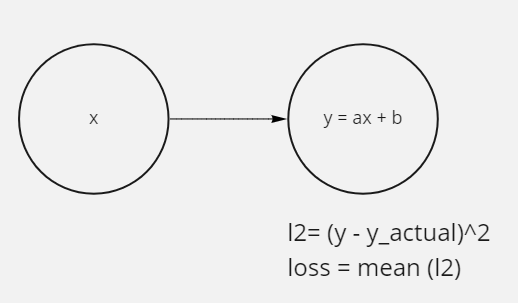

 # Let's use pytorch for this

 ### Linear Function again
 $ f(x) = ax + b $

In [ ]:
"""Setting up a linear function again"""
x = np.arange(-10, 11).astype("float32")
print("x:", x)
y_actual = 0.5 * x + 2
print("y_actual:", y_actual)

y = y_actual + np.random.randn(21) * 0.5
y = y.astype("float32")
print("y (sample data):", y)


In [ ]:
# define a training loop
def train(model, x, y, learning_rate=0.01, num_epochs=100, loss_fn = torch.nn.MSELoss(), batch_size=21):

  # Create a TensorDataset
  dataset = TensorDataset(x_tensor, y_tensor)

  # Create a DataLoader
  dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

  # Create optimizer
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

  model.train()
  for epoch in range(num_epochs):
    for i, (batch_x, batch_y) in enumerate(dataloader):
      optimizer.zero_grad()
      y_pred = model(batch_x)
      loss = loss_fn(y_pred, batch_y)
      loss.backward()
      optimizer.step()

    if epoch % 10 == 0:
      print("Epoch:", epoch, "Loss:", loss.item())

  return model




In [ ]:
class LinearModel(nn.Module):
  def __init__(self):
    super(LinearModel, self).__init__()
    self.fc = nn.Linear(1, 1)  # 1 input feature, 1 output feature

  def forward(self, x):
    return self.fc(x)

model = LinearModel()

# Convert numpy arrays to torch tensors
x_tensor = torch.from_numpy(x).unsqueeze(1)
y_tensor = torch.from_numpy(y).unsqueeze(1)

print("Weights before:", model.fc.weight, model.fc.bias)

model = train(model, x_tensor, y_tensor, num_epochs=10, learning_rate=0.01, batch_size=21)

print("Prediction:", model(x_tensor).squeeze())
print("Weights after:", model.fc.weight, model.fc.bias)

plt.scatter(x, y)
plt.plot(x, y_actual)
plt.plot(x, model(x_tensor).squeeze().detach().numpy())

## Discussion point:
 - Observe the weight values before and after training
 - Observe what happens when you change the number of epochs
 - Observe what happens when you change the learning rate

 A non linear function
# $ f(x) = x^2 $

In [ ]:
x = np.arange(-10, 11)*1.0
print("x:", x)
y_actual = x * x * 1.0
print("y_actual:", y_actual)

y = y_actual + 0 #np.random.randn(21) * 10

plt.plot(x, y_actual)
plt.scatter(x, y)
plt.show()

 ### Discussion point:
 - What do we expect our linear model would do?

In [ ]:
class LinearModel(nn.Module):
  def __init__(self):
    super(LinearModel, self).__init__()
    self.fc = nn.Linear(1, 1)  # 1 input feature, 1 output feature

  def forward(self, x):
    return self.fc(x)

model = LinearModel()

# Convert numpy arrays to torch tensors
x_tensor = torch.from_numpy(x).unsqueeze(1).float()
y_tensor = torch.from_numpy(y).unsqueeze(1).float()

print("Weights before:", model.fc.weight, model.fc.bias)

model = train(model, x_tensor, y_tensor, num_epochs=10, learning_rate=0.01, batch_size=21)

print("Prediction:", model(x_tensor).squeeze())
print("Weights after:", model.fc.weight, model.fc.bias)

plt.scatter(x, y)
plt.plot(x, y_actual)
plt.plot(x, model(x_tensor).squeeze().detach().numpy())

 # Activations: Linear followed by Non Linear

 ## Rectified Linear Units (ReLU)

 $ y = ReLU(ax + b)$

 $ReLU(z) =
 \begin{cases}
 z > 0,  & \text{return z} \\
 z < 0, & \text{return 0}
 \end{cases}$

 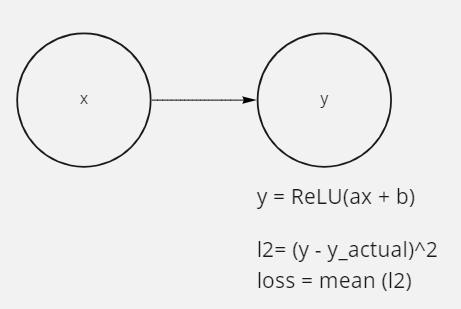

In [ ]:


class LinearModel(nn.Module):
  def __init__(self):
    super(LinearModel, self).__init__()
    self.fc = nn.Linear(1, 1)  # 1 input feature, 1 output feature

  def forward(self, x):
    x = self.fc(x)
    return F.relu(x)

model = LinearModel()

# Convert numpy arrays to torch tensors
x_tensor = torch.from_numpy(x).unsqueeze(1).float()
y_tensor = torch.from_numpy(y).unsqueeze(1).float()

print("Weights before:", model.fc.weight, model.fc.bias)

model = train(model, x_tensor, y_tensor, num_epochs=10, learning_rate=0.01, batch_size=21)

print("Prediction:", model(x_tensor).squeeze())
print("Weights after:", model.fc.weight, model.fc.bias)

plt.scatter(x, y)
plt.plot(x, y_actual)
plt.plot(x, model(x_tensor).squeeze().detach().numpy())

 # A multi layered neural network
 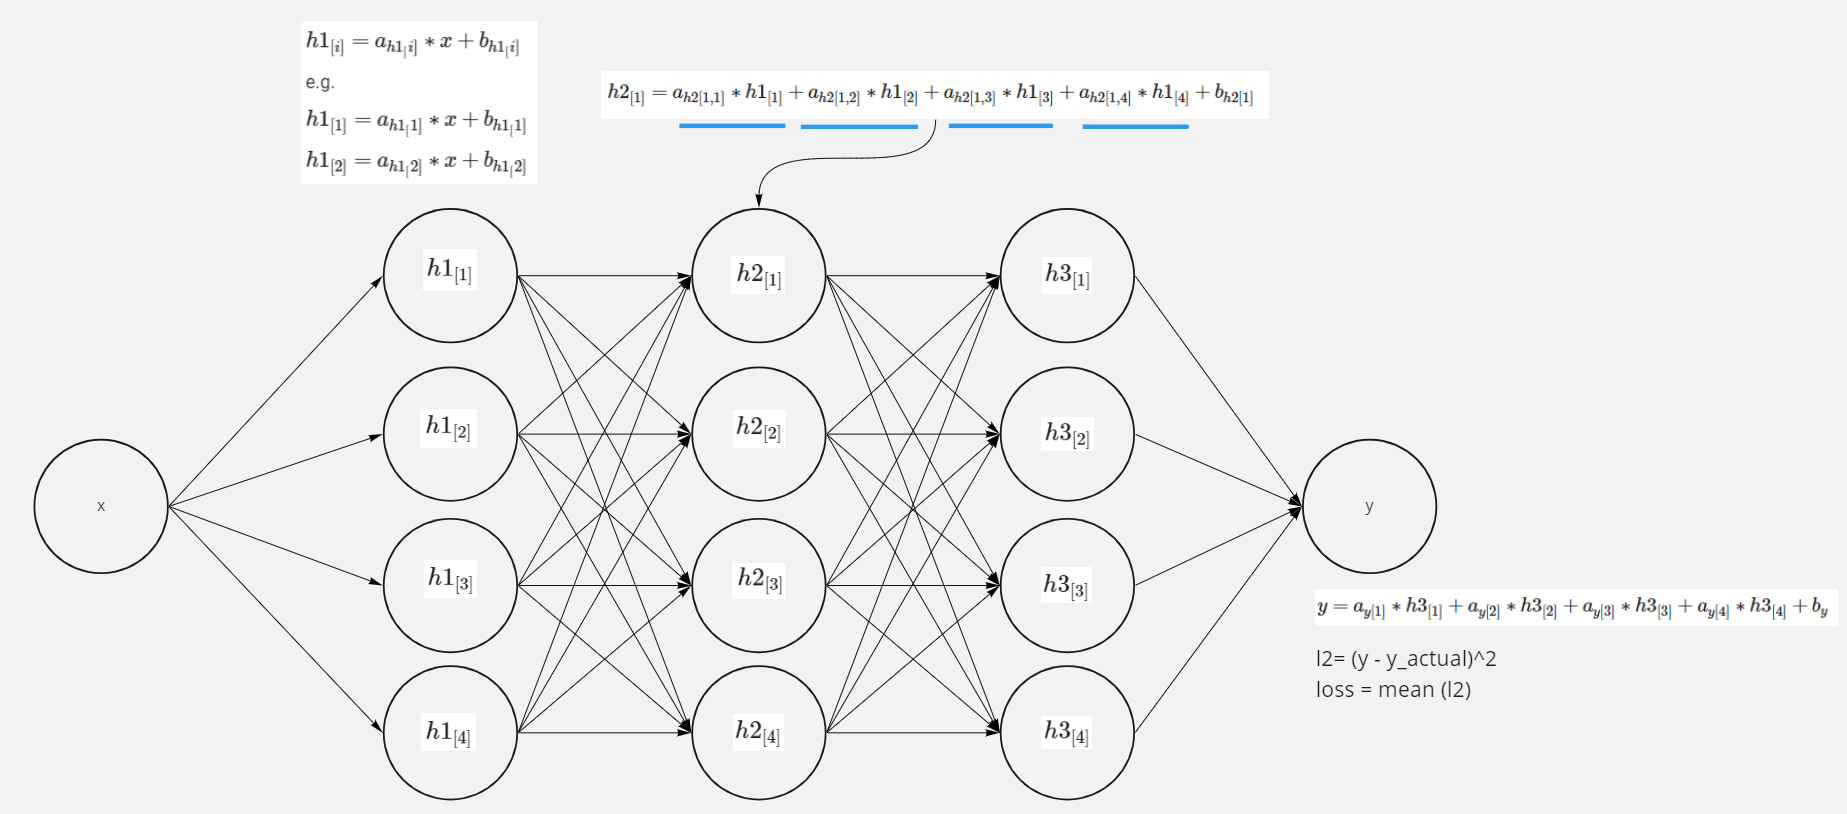

In [ ]:
class LinearModel(nn.Module):
  def __init__(self):
    super(LinearModel, self).__init__()
    self.fc1 = nn.Linear(1, 64)  # 1 input feature, 64 output feature
    self.fc2 = nn.Linear(64, 64)  # 64 input feature, 64 output feature
    self.fc3 = nn.Linear(64, 64)  # 64 input feature, 64 output feature
    self.fc4 = nn.Linear(64, 1)  # 64 input feature, 1 output feature

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = F.relu(self.fc4(x))
    return x

model = LinearModel()

# Convert numpy arrays to torch tensors
x_tensor = torch.from_numpy(x).unsqueeze(1).float()
y_tensor = torch.from_numpy(y).unsqueeze(1).float()

# print("Weights before:", model.fc1.weight, model.fc1.bias)

model = train(model, x_tensor, y_tensor, num_epochs=1000, learning_rate=0.0001, batch_size=21)

print("Prediction:", model(x_tensor).squeeze())
# print("Weights after:", model.fc1.weight, model.fc1.bias)

plt.scatter(x, y)
plt.plot(x, y_actual)
plt.plot(x, model(x_tensor).squeeze().detach().numpy())

 ### Discussion point:
 - What is happening when we combine a linear model with a non-linear activation?
 - What is happening when we run a deep model with multiple layers?
 - Play around with the learning rate, and different layers to see what happens.
 - What happens when we try to predit a number beyond -10 and +10?

In [ ]:
print(model(torch.tensor([20.0]).unsqueeze(1)))   # this is probably far off from 20*20

 # A more complicated function. Let's do a classification task.
 $x_1 = english\ mark$
 $x_2 = math\ mark$
 $PassTest(x_1, x_2) =
 \begin{cases}
 x_1 > 50 \ and \ x_2 > 50,  & \text{return [1, 0]} \\
 everything else, & \text{return [0, 1]}
 \end{cases}$
 # Softmax as activation
 $$
 \sigma(\mathbf{z})_j = \frac{e^{z_j}}{\sum_{k=1}^{K} e^{z_k}}
 $$
 # Negative Log (x)
 $$
 -\log(x) = \log(\frac{1}{x}) = \log(1) - \log(x) = -\log(x)
 $$

 ![log(x)](https://www.varsitytutors.com/assets/vt-hotmath-legacy/hotmath_help/topics/graphing-logarithmic-functions/f-gr-log-fn_1_4_1.gif)

 see google for graph of -log(x)

In [ ]:
def softmax(z):
  e_z = torch.exp(z)
  return e_z / torch.sum(e_z)

z = torch.tensor([1, 2, 3])
print(softmax(z))

In [ ]:
# Let's generate some data
x = np.random.randint(30, 100, 4000) # generate 2000 random samples between 0-100
x = np.reshape(x, (-1, 2))  # reshape into 100 [a, b] values
print("x.shape:", x.shape)

# print(x[:10])

"""Define our PassTest function"""
def pass_test(marks):
    passed = np.zeros(marks.shape[0])
    passed[(marks[:, 0] > 50) & (marks[:, 1] > 50)] = 1
    failed = np.zeros(marks.shape[0])
    failed[(passed == 0)] = 1
    return np.column_stack((passed, failed))

y = pass_test(x)
print("y.shape:", y.shape)
# let's see the first 10 values
for i in range(10):
    print(i, x[i], y[i])


In [ ]:
class LinearModel(nn.Module):
  def __init__(self):
    super(LinearModel, self).__init__()
    self.fc1 = nn.Linear(2, 256)  # 1 input feature, 256 output feature
    self.fc2 = nn.Linear(256, 256)  # 256 input feature, 256 output feature
    self.fc3 = nn.Linear(256, 256)  # 256 input feature, 256 output feature
    self.fc4 = nn.Linear(256, 2)  # 256 input feature, 1 output feature

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = F.relu(self.fc4(x))
    return F.softmax(x, dim=1)

model = LinearModel()



In [ ]:
##### Test some sample data to see that the model is random
test_data = np.random.randint(0, 100, 200)
test_data = np.reshape(test_data, (-1, 2))
actual = pass_test(test_data)

model_input = torch.from_numpy(test_data/100.).float()  ## note: we reduce the input data to be between 0 and 1 to make training more stable
prediction = np.round(model(model_input).detach().numpy(), 2)

for i in range(30):
    print(i, test_data[i], "Actual:", actual[i],
          "Prediction:", "[{:.2f}, {:.2f}]".format(prediction[i][0], prediction[i][1]),
          "matched:", np.argmax(actual[i]) == np.argmax(prediction[i]),
          "confidence:", prediction[i][np.argmax(prediction[i])])




In [ ]:
# define our loss function
def loss_function_for_exams(y_pred, y_true):
  return torch.sum(y_true * -torch.log(y_pred), dim=1).mean() # y_true * -log(y_pred) so that we only calculate the loss for the correct class

# Convert numpy arrays to torch tensors
x_tensor = torch.from_numpy(x/100.).float() ## note: we reduce the input data to be between 0 and 1
y_tensor = torch.from_numpy(y).float()

model = train(model, x_tensor, y_tensor, num_epochs=400, learning_rate=0.01, batch_size=64, loss_fn=loss_function_for_exams)


In [ ]:
##### Test the same sample data after the model has been trained
prediction = np.round(model(model_input).detach().numpy(), 2)

for i in range(30):
    print(i, test_data[i], "Actual:", actual[i],
          "Prediction:", "[{:.2f}, {:.2f}]".format(prediction[i][0], prediction[i][1]),
          "matched:", np.argmax(actual[i]) == np.argmax(prediction[i]),
          "confidence:", prediction[i][np.argmax(prediction[i])])